<a href="https://colab.research.google.com/github/Priyo-prog/Time-series-analysis/blob/main/The%20ARIMA%20Model/the_arima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**The ARIMA Model**

The **ARIMA** model has 3 orders **(p,d,q)**

**p :** - represents **AR** lags

**q :** - represents **MA** lags

**d :** - represents the integration order. The times we need to integrate the time-series to ensure stationarity.

Accounting for non-seasonal difference between periods.

**No Integration** :

**ARIMA(p,0,q)** = **ARMA(p,q)**

**ARIMA(0,0,q)** = **MA(q)**

**ARIMA(p,0,0)** = **AR(p)**

ARIMA models are more computationally intensive than the ARMA models

## Import the Libraries and Packages

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA # new special package for ARIMA models
from scipy.stats.distributions import chi2
import seaborn as sns
sns.set()

## Import the Data

In [30]:
## mount the google drive to fetch the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
## load the dataset
raw_csv_data = pd.read_csv('/content/drive/MyDrive/Data Science/Time Series/Index2018.csv')
raw_csv_data.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


## Preprocess the Data

In [32]:
## transforming the dataset
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b') # business days as frequency
df_comp = df_comp.fillna(method='ffill')

In [33]:
df_comp['market_value'] = df_comp.ftse

In [34]:
del df_comp['dax'], df_comp['ftse'], df_comp['nikkei']

## Splitting the Training and Testing Set

In [35]:
## Getting the 80% of data as training set
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The Log-Likelihood Ratio Test

In [36]:
def llr_test(mod_1, mod_2, DF=1):
   """ mod_1, mod_2= models to compare, df=degrees of freedom"""
   L1 = mod_1.fit(trend='nc').llf ## Add trend='ct'
   L2 = mod_2.fit(trend='nc').llf ## log likelihood
   LR = (2*(L2-L1)) ## test statistics
   p = chi2.sf(LR, DF).round(3) ## p-value
   return p

## Creating Returns

In [37]:
df['returns'] = df.market_value.pct_change(1).mul(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## ARIMA(1,1,1)

In [38]:
model_ar_1_i_1_ma_1 = ARIMA(df.market_value, order=(1,1,1))
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
print(results_ar_1_i_1_ma_1.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Wed, 03 Aug 2022   AIC                          55215.333
Time:                        06:06:38   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5655      0.682      0.829      0.407      -0.772       1.903
ar.L1.D.market_value     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.D.mark

The above results show only 2 coefficients of AR and MA.

The integration order (d) has no effect on the number of parameters we need to estimate.

We are transforming the underlying data while no modelling is performed.

## Residuals of the ARIMA(1,1,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


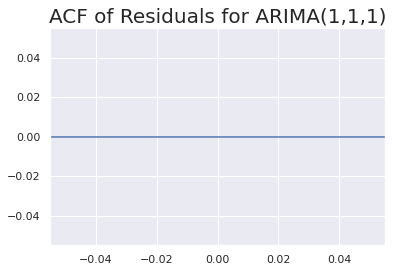

In [39]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_1, zero=False, lags=40)
plt.title("ACF of Residuals for ARIMA(1,1,1)", size=20)
plt.show()

In the above graph, we just find a straight line.

The ACF failed to compute due to the missing value at the first element.

We need to use the residuals from the 2nd period onwards.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


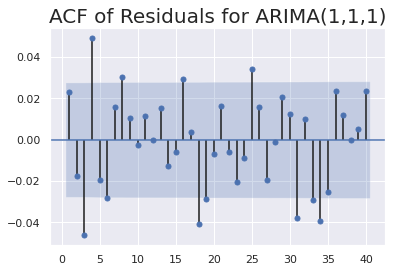

In [40]:
df['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid
sgt.plot_acf(df.res_ar_1_i_1_ma_1[1:], zero=False, lags=40)
plt.title("ACF of Residuals for ARIMA(1,1,1)", size=20)
plt.show()

## Higher Lag ARIMA Model

In [41]:
model_ar_1_i_1_ma_2 = ARIMA(df.market_value, order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()

model_ar_1_i_1_ma_3 = ARIMA(df.market_value, order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()

model_ar_2_i_1_ma_1 = ARIMA(df.market_value, order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()

model_ar_3_i_1_ma_1 = ARIMA(df.market_value, order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()

model_ar_3_i_1_ma_2 = ARIMA(df.market_value, order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_ar_lags=5)

## Print the Log-Likelihood and the Information Criterion AIC

In [42]:
print("ARIMA(1,1,1): \tLL = ", results_ar_1_i_1_ma_1.llf, "\t AIC = ", results_ar_1_i_1_ma_1.aic)
print("ARIMA(1,1,2): \tLL = ", results_ar_1_i_1_ma_2.llf, "\t AIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMA(1,1,3): \tLL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(2,1,1): \tLL = ", results_ar_2_i_1_ma_1.llf, "\t AIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMA(3,1,1): \tLL = ", results_ar_3_i_1_ma_1.llf, "\t AIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMA(3,1,2): \tLL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)

ARIMA(1,1,1): 	LL =  -27603.666412774845 	 AIC =  55215.33282554969
ARIMA(1,1,2): 	LL =  -27600.081863139967 	 AIC =  55210.163726279934
ARIMA(1,1,3): 	LL =  -27590.424032545823 	 AIC =  55192.848065091646
ARIMA(2,1,1): 	LL =  -27599.80748784872 	 AIC =  55209.61497569744
ARIMA(3,1,1): 	LL =  -27592.05537170885 	 AIC =  55196.1107434177
ARIMA(3,1,2): 	LL =  -27590.660808987082 	 AIC =  55195.321617974165


ARIMA(1,1,3) has highest Log-Likelihood and lowest information criterion AIC.

ARIMA(1,1,1) and ARIMA(1,1,3) are nested therefore we will examine the LLR Test.

In [43]:
print("\nLLR test p-value = " + str(llr_test(model_ar_1_i_1_ma_2, model_ar_1_i_1_ma_3)))


LLR test p-value = 0.0


In [44]:
print("\nLLR test p-value = " + str(llr_test(model_ar_1_i_1_ma_1, model_ar_1_i_1_ma_3, DF=2)))


LLR test p-value = 0.0


## Plot the ACF

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


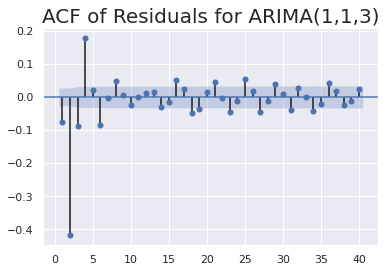

In [45]:
df['res_ar_1_i_1_ma_3'] = results_ar_1_i_1_ma_3.resid.iloc[:]
sgt.plot_acf(df.res_ar_1_i_1_ma_3[1:], zero=False, lags=40)
plt.title("ACF of Residuals for ARIMA(1,1,3)", size=20)
plt.show()

In [46]:
model_ar_5_i_1_ma_1 = ARIMA(df.market_value, order=(5,1,1))
results_ar_5_i_1_ma_1 = model_ar_5_i_1_ma_1.fit(start_ar_lags=11)

model_ar_6_i_1_ma_3 = ARIMA(df.market_value, order=(6,1,3))
results_ar_6_i_1_ma_3 = model_ar_6_i_1_ma_3.fit(start_ar_lags=11)

## Log-Likelihood and AIC of ARIMA(5,1,1) and ARIMA(6,1,1)

In [47]:
print("ARIMA(1,1,3): \tLL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMA(5,1,1): \tLL = ", results_ar_5_i_1_ma_1.llf, "\t AIC = ", results_ar_5_i_1_ma_1.aic)
print("ARIMA(6,1,3): \tLL = ", results_ar_6_i_1_ma_3.llf, "\t AIC = ", results_ar_6_i_1_ma_3.aic)

ARIMA(1,1,3): 	LL =  -27590.424032545823 	 AIC =  55192.848065091646
ARIMA(5,1,1): 	LL =  -27586.51188812616 	 AIC =  55189.02377625232
ARIMA(6,1,3): 	LL =  -27583.565320399106 	 AIC =  55189.13064079821


Since both ARIMA(1,1,3) and ARIMA(5,1,1) are nested in ARIMA(6,1,3) we can examine the LLR test.

In [48]:
print("\nLLR test p-value = " + str(llr_test(model_ar_1_i_1_ma_3, model_ar_6_i_1_ma_3, DF=5)))


LLR test p-value = 0.003


In [49]:
print("\nLLR test p-value = " + str(llr_test(model_ar_5_i_1_ma_1, model_ar_6_i_1_ma_3, DF=3)))


LLR test p-value = 0.018


## The ACF of ARIMA(5,1,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


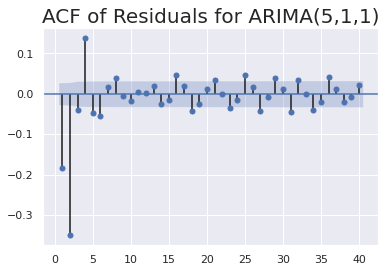

In [50]:
df['res_ar_5_i_1_ma_1'] = results_ar_5_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df.res_ar_5_i_1_ma_1[1:], zero=False, lags=40)
plt.title("ACF of Residuals for ARIMA(5,1,1)", size=20)
plt.show()

## Models of Higher Levels of Integration

We rely on on integration, when our time-series doesn't come from a stationary process.

If a single layer of integration (d=1) accomplishes this, any additional ones are unnecessary.

How do we know if the integrated data set is stationary ?

1) Manually create an integrated version of the original time-series.

2) Use the Augmented Dickey-Fuller Test.

In [51]:
## We use delta to describe the differences between the values of a series
df['delta_prices'] = df.market_value.diff(1)

model_delta_ar_1_i_1_ma_1 = ARIMA(df.delta_prices[1:], order=(1,0,1))
results_delta_ar_1_i_1_ma_1 = model_delta_ar_1_i_1_ma_1.fit()
print(results_delta_ar_1_i_1_ma_1.summary())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


                              ARMA Model Results                              
Dep. Variable:           delta_prices   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood              -27603.666
Method:                       css-mle   S.D. of innovations             59.134
Date:                Wed, 03 Aug 2022   AIC                          55215.333
Time:                        06:07:14   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5655      0.682      0.829      0.407      -0.772       1.903
ar.L1.delta_prices     0.7475      0.070     10.652      0.000       0.610       0.885
ma.L1.delta_prices  

## The Augmented Dickey-Fuller Test

In [52]:
sts.adfuller(df.delta_prices[1:])

(-32.244093495707475,
 0.0,
 5,
 5014,
 {'1%': -3.4316548765428174,
  '10%': -2.5670769326348926,
  '5%': -2.8621166146845334},
 54845.96104221891)

The Dickey-Fuller test shows we don't need additional layer of Integration

ARIMA models are more suited for the non-stationary data but are more computationally intensive than ARMA models.

By integrating more stationary data we are making more difficult for the model to estimate the coefficients.

ARIMA needs to generate every layer of integration one by one and then try to fit the new data using any of the ARMA models we are familiar with.

Another issue with integarted models we face with is **data attrition**. It means we lose observations because of **conversions of Prices to Returns**. And then we lose more observations on each layers of integration.

**Issues: **

1) The more layers, the more background work the models need to do before fitting the data.

2) Not only we have to transform the data but we have to differentaite the values from zero.

3) Data fails to converge even after 10s and 1000s of iteration.

4) When the numbers are too small we may face numerical instability.

## ARIMAX

A model that takes into acount more than just past prices or past residuals are known as **"max"** models.

ARMAX - non-integrated models

ARIMAX - intergrated models

We also need to specify the exogenous arguement callled **"exog"**

In [58]:
model_ar_1_i_1_ma_1_Xspx = ARIMA(df.market_value, exog=df.spx, order=(1,1,1))
results_ar_1_i_1_ma_1_Xspx = model_ar_1_i_1_ma_1_Xspx.fit()
print(results_ar_1_i_1_ma_1_Xspx.summary())

                             ARIMA Model Results                              
Dep. Variable:         D.market_value   No. Observations:                 5020
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27603.556
Method:                       css-mle   S.D. of innovations             59.132
Date:                Wed, 03 Aug 2022   AIC                          55217.112
Time:                        06:26:15   BIC                          55249.718
Sample:                    01-10-1994   HQIC                         55228.538
                         - 04-05-2013                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5874      2.655     -0.221      0.825      -5.790       4.616
spx                      0.0011      0.002      0.451      0.652      -0.004       0.006
ar.L1.D.mark

## SARIMAX

Including the seasonal orders of AR and MA apart from order **(p,d,q)** also include **(P,D,Q,s)**

**s** - Length of the season

In [55]:
## let's include SARIMAX (1,0,1) as non-seasonal data
## (2,0,1,5) as seasonal data and S&P as exogenous data

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [59]:
model_sarimax = SARIMAX(df.market_value, exog=df.spx, order=(1,0,1), seasonal_order=(2,0,1,5))
results_sarimax = model_sarimax.fit()
print(results_sarimax.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                      market_value   No. Observations:                 5021
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 5)   Log Likelihood              -26712.653
Date:                           Wed, 03 Aug 2022   AIC                          53439.307
Time:                                   06:26:49   BIC                          53484.956
Sample:                               01-07-1994   HQIC                         53455.303
                                    - 04-05-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spx            2.7053      0.035     77.494      0.000       2.637       2.774
ar.L1          0.9998      0.000   2314.161